In [1]:
import torch
import monai
import numpy as np
from tqdm import tqdm
from pathlib import Path
import pandas as pd
from monai.transforms import (
    Compose,
    EnsureChannelFirst,
    EnsureType,
    LoadImage,
    Orientation,
    ToDevice
)
from scipy import stats
import plotly.graph_objects as go
import plotly.express as px
from numpy.random import default_rng
import matplotlib.pyplot as plt
from monai.metrics import DiceMetric, SurfaceDistanceMetric


In [2]:
task = "MSD_Task07_Pancreas"
models_path = Path(f"/home/exouser/Repositories/AutoSeg3D/{task}")
dataset_path = Path("/media/volume/CT-RATE/CT-FM/MedicalSegmentationDecathlon") / "_".join(models_path.stem.split("_")[1:])

model_preds = {}
for folder in models_path.glob("*"):
    if folder.is_dir():
        preds_path = folder / "segresnet_0" / "prediction_testing"
        if preds_path.is_dir():
            model_preds[folder.stem] = preds_path


In [3]:
model_dir = {}
for key, model in model_preds.items():
    model_path = str(model).replace("prediction_testing", "model") + "/model.pt"
    model = torch.load(model_path)
    print(key, model['epoch'], model['best_metric'])

In [118]:
import gc
device = "cuda:0"
classes = ["background", "organ","cancer"]

base_transforms = Compose([
    LoadImage(),
    ToDevice(device=device),
    EnsureChannelFirst(),
    EnsureType(data_type="tensor", dtype="int"),
    Orientation(axcodes="RAS"),
])

dice_dict = {key: {k: {} for k in classes} for key in model_preds.keys()}
distance_dict = {key: {k: {} for k in classes} for key in model_preds.keys()}
for model, path in model_preds.items():
    print(f"Evaluating {model} ...")
    pred_paths = list(path.rglob("*.nii.gz"))
    for pred_path in tqdm(pred_paths):
        pred_label = pred_path.stem.split(".")[0]
        gt_path = dataset_path / str(pred_path.relative_to(path)).replace("images", "labels")
        gt = base_transforms(gt_path).unsqueeze(0)

        pixdim = gt.meta['pixdim'][1:4]
        pred = base_transforms(pred_path).unsqueeze(0)

        pred_one_hot = monai.networks.utils.one_hot(pred, num_classes=len(classes))
        gt_one_hot = monai.networks.utils.one_hot(gt, num_classes=len(classes))

        res = monai.metrics.compute_dice(pred, gt, num_classes=len(classes)).squeeze().tolist()
        for idx, (label, value) in enumerate(zip(classes, res)):
            if idx == 0:
                continue

            if np.all(np.array(gt_one_hot.cpu()[:, idx]) == 0):
                print(f"Skipped {pred_label}: {label}")
                continue
            
            dice_dict[model][label][pred_label] = value

            if idx == len(classes) - 1:
                distance_res = monai.metrics.compute_average_surface_distance(pred_one_hot[:, idx].unsqueeze(0), gt_one_hot[:, idx].unsqueeze(0), spacing=pixdim.tolist())
                distance_dict[model][label][pred_label] = distance_res.item()
            gc.collect()

    

Evaluating ct_fm_finetune ...


  0%|          | 0/56 [00:00<?, ?it/s]../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [24797,0,0], thread: [96,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [24440,0,0], thread: [32,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [24440,0,0], thread: [33,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [24440,0,0], thread: [34,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [24441,0,0], thread: [96,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/nativ

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [103]:
import pandas as pd
dice_df = pd.DataFrame(dice_dict)
asd_df = pd.DataFrame(distance_dict)

dice_df.drop('background', inplace=True)
asd_df.drop('background', inplace=True)

In [119]:
dice_df_melted = dice_df.melt(
    ignore_index=False,
    var_name='Model',
    value_name='Dice'
)

dice_df_melted = dice_df_melted.reset_index().rename(columns={'index': 'Label'})
dice_df_melted = dice_df_melted.dropna()

In [105]:
dice_df_melted

,Label,Model,Dice
0,cancer,ct_fm_finetune,"{'lung_080': 0.34377437829971313, 'lung_081': ..."
1,cancer,ct_fm,"{'lung_080': 0.36042529344558716, 'lung_081': ..."
2,cancer,baseline,"{'lung_080': 0.30269649624824524, 'lung_081': ..."


In [106]:
dice_df_melted = dice_df_melted[dice_df_melted["Model"].isin(["ct_fm" if task == "MSD_Task08_HepaticVessel" else "ct_fm_finetune", "baseline"])]

In [107]:
asd_df_melted = asd_df.melt(
    ignore_index=False,
    var_name='Model',
    value_name='Distance'
)

asd_df_melted = asd_df_melted.reset_index().rename(columns={'index': 'Label'})
asd_df_melted = asd_df_melted.dropna()

asd_df_melted

,Label,Model,Distance
0,cancer,ct_fm_finetune,"{'lung_080': 36.981510162353516, 'lung_081': 1..."
1,cancer,ct_fm,"{'lung_080': 39.50809860229492, 'lung_081': 17..."
2,cancer,baseline,"{'lung_080': 38.37458038330078, 'lung_081': 20..."


In [108]:
asd_df_melted= asd_df_melted[asd_df_melted["Model"].isin(["ct_fm" if task == "MSD_Task08_HepaticVessel" else "ct_fm_finetune", "baseline"])]


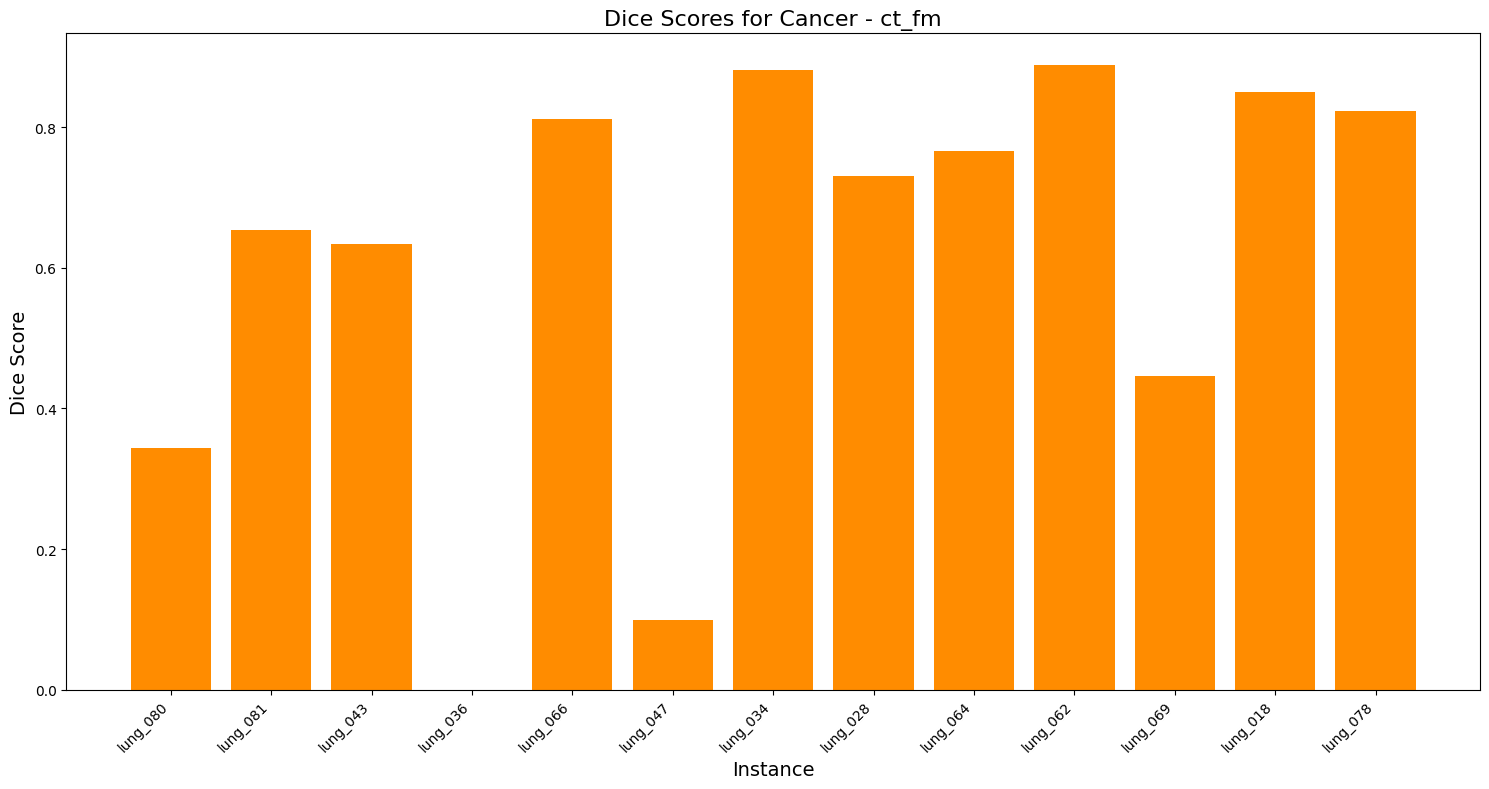

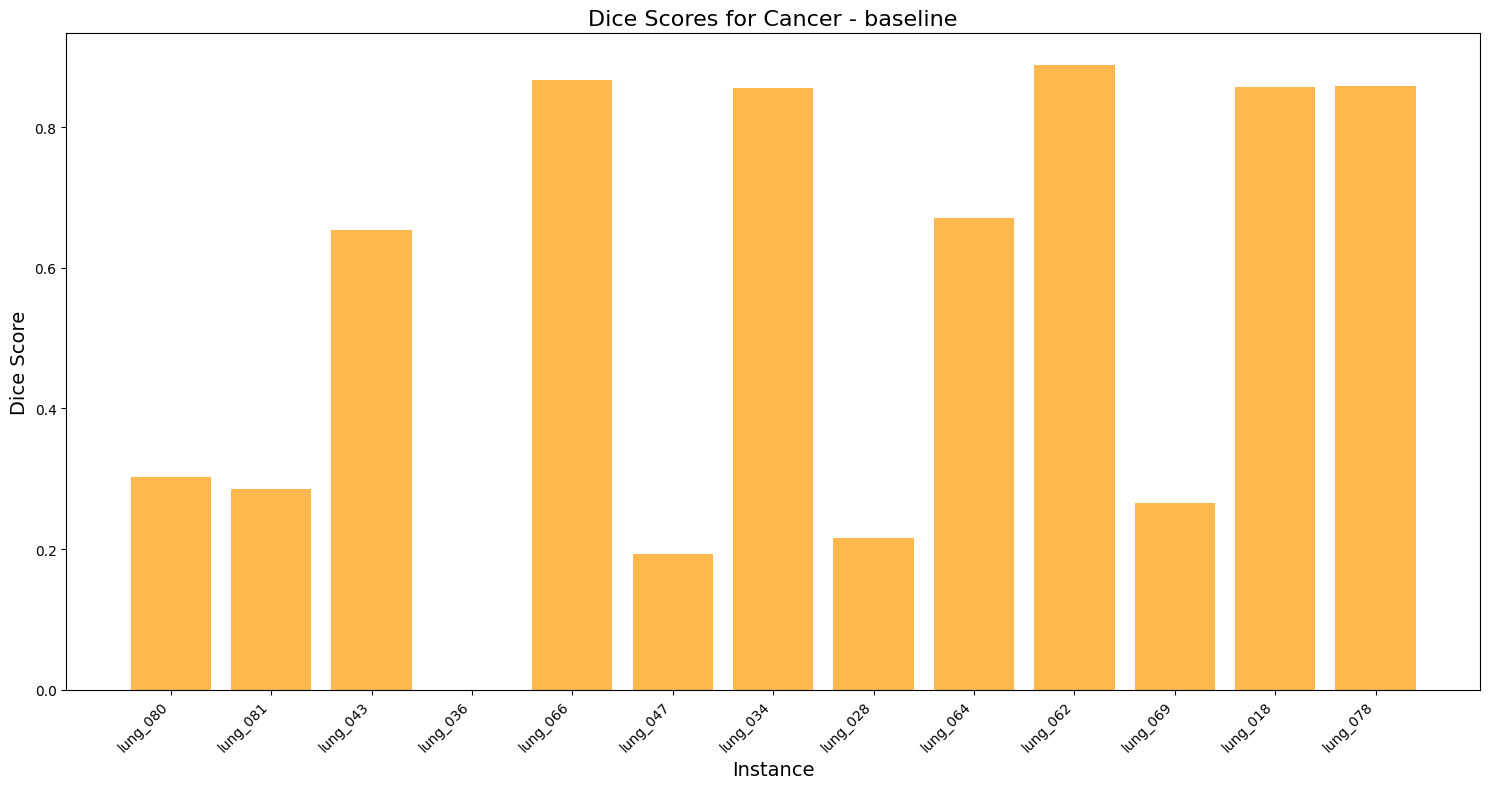

In [109]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Filter for cancer data
cancer_dice_df = dice_df_melted[dice_df_melted["Label"] == "cancer"].copy()

# Function to extract and plot dice values
def plot_dice_values(df, model_name, color):
    dice_values = []
    labels = []
    for index, row in df.iterrows():
        if isinstance(row['Dice'], dict):
            dice_values.extend(row['Dice'].values())
            labels.extend(row['Dice'].keys())
        else:
            dice_values.extend(row['Dice'])
            labels.extend([f"instance_{i}" for i in range(len(row['Dice']))])
    
    
    plt.figure(figsize=(15, 8))
    plt.bar(range(len(dice_values)), dice_values, color=color)
    plt.title(f'Dice Scores for Cancer - {model_name}', fontsize=16)
    plt.xlabel('Instance', fontsize=14)
    plt.ylabel('Dice Score', fontsize=14)
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right", fontsize=10)
    plt.subplots_adjust(bottom=0.3)
    plt.tight_layout()
    plt.show()

# Plot for ct_fm
ct_fm_df = cancer_dice_df[cancer_dice_df["Model"] == "ct_fm_finetune"]
plot_dice_values(ct_fm_df, "ct_fm", "#FF8C00")

# Plot for baseline
baseline_df = cancer_dice_df[cancer_dice_df["Model"] == "baseline"]
plot_dice_values(baseline_df, "baseline", "#FFB84D")

In [110]:
dice_df_melted["Dice"] = dice_df_melted["Dice"].apply(lambda x: list(x.values()))
dice_df_melted["Mean Dice"] = dice_df_melted["Dice"].apply(lambda x: np.nanmean([val for val in x if not np.isinf(val) and not np.isnan(val)]))

asd_df_melted["Distance"] = asd_df_melted["Distance"].apply(lambda x: list(x.values()))
asd_df_melted["Mean Distance"] = asd_df_melted["Distance"].apply(lambda x: np.nanmean([val for val in x if not np.isinf(val) and not np.isnan(val)]))

/tmp/ipykernel_371651/2470083099.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_371651/2470083099.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_371651/2470083099.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykerne

In [111]:
dice_df_melted = dice_df_melted[dice_df_melted["Label"] == "cancer"]
asd_df_melted = asd_df_melted[asd_df_melted["Label"] == "cancer"]

In [112]:
dice_df_melted

,Label,Model,Dice,Mean Dice
0,cancer,ct_fm_finetune,"[0.34377437829971313, 0.6531447172164917, 0.63...",0.609734
2,cancer,baseline,"[0.30269649624824524, 0.2859833538532257, 0.65...",0.531945


In [113]:
asd_df_melted

,Label,Model,Distance,Mean Distance
0,cancer,ct_fm_finetune,"[36.981510162353516, 103.0697021484375, 12.939...",48.340716
2,cancer,baseline,"[38.37458038330078, 206.56539916992188, 0.5048...",62.097759


In [100]:

color_list = ["#FF8C00",  "#FFB84D", "#FFD700", "#FFA07A"]

font_size = 20

def bootstrap_confidence_interval(data, confidence_level=0.95, n_iterations=10000):
    """
    Calculate the confidence interval for the mean of the given data using bootstrapping.

    Parameters:
    - data: list or array-like, the sample data
    - confidence_level: float, the confidence level for the interval (default is 0.95)
    - n_iterations: int, the number of bootstrap iterations (default is 10,000)

    Returns:
    - tuple containing the lower and upper bounds of the confidence interval
    """

    rng = default_rng()  # Random number generator
    data = [x for x in data if not np.isnan(x) and not np.isinf(x)]  # Remove nan and inf values

    means = []
    for _ in range(n_iterations):
        # Generate a bootstrap sample with replacement
        sample = rng.choice(data, size=len(data), replace=True)
        # Calculate and store the mean of the bootstrap sample
        means.append(np.mean(sample))
        
    # Calculate the percentiles for the confidence interval
    lower_percentile = ((1.0 - confidence_level) / 2.0) * 100
    upper_percentile = (confidence_level + (1.0 - confidence_level) / 2.0) * 100

    print(lower_percentile, upper_percentile)
    ci = np.percentile(means, [lower_percentile, upper_percentile])
    print(ci)

    return np.mean(data) - ci[0], ci[1] - np.mean(data)


# Calculate 95% confidence intervals
def calculate_ci(data):
    data = [x for x in data if not np.isnan(x)]  # Remove nan values
    if len(data) < 2:  # Check if we have enough data points after removing nans
        return 0, 0  # Return 0 for both lower and upper CI if not enough data
    ci = stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data))
    return np.mean(data) - ci[0], ci[1] - np.mean(data)

dice_df_melted['CI_lower'], dice_df_melted['CI_upper'] = zip(*dice_df_melted['Dice'].apply(bootstrap_confidence_interval))

fig = px.bar(
    dice_df_melted,
    x='Label',
    y='Mean Dice',
    color='Model',
    height=600,
    width=400,
    opacity=0.7,
    range_y=[0.3, 0.8],
    barmode="group",
    template='plotly_white',
    color_discrete_sequence=color_list,
    error_y='CI_upper',
    error_y_minus='CI_lower'
)

fig.update_traces(
    textfont=dict(size=font_size),  # Increase text size
)

fig.update_layout(
    font=dict(size=font_size),  # Increase overall font size
    xaxis=dict(tickfont=dict(size=font_size), title=None),  # Remove x-axis label
    yaxis=dict(tickfont=dict(size=font_size)),  # Increase y-axis tick label size
    legend=dict(font=dict(size=font_size), orientation="v", yanchor="bottom", y=1, xanchor="right", x=1.2)  # Move legend to top
)

# Update scatter plot markers and show x and y axes
fig.update_traces(
    marker=dict(size=8, symbol='circle', line=dict(width=1, color='DarkSlateGrey')),
    selector=dict(mode='markers')
)
fig.update_layout(
    xaxis=dict(showline=True, linewidth=2, linecolor='black', mirror=False),
    yaxis=dict(showline=True, linewidth=2, linecolor='black', mirror=False)
)

fig.show()

2.500000000000002 97.5
[0.4445536 0.7537734]
2.500000000000002 97.5
[0.35967933 0.70239349]


In [101]:
dice_df_melted

,Label,Model,Dice,Mean Dice,CI_lower,CI_upper
0,cancer,ct_fm_finetune,"[0.34377437829971313, 0.6531447172164917, 0.63...",0.609734,0.165180,0.144040
2,cancer,baseline,"[0.30269649624824524, 0.2859833538532257, 0.65...",0.531945,0.172265,0.170449


In [59]:
# Perform Wilcoxon signed-rank test for paired data
from scipy import stats

# Group the data by Label
grouped = asd_df_melted.groupby('Label')

p_values = {}

for label, group in grouped:
    models = group['Model'].unique()
    
    if len(models) == 2:  # We need exactly two models to compare
        model1_data = group[group['Model'] == models[0]]['Distance'].iloc[0]
        model2_data = group[group['Model'] == models[1]]['Distance'].iloc[0]
        
        model1_values = model1_data
        model2_values = model2_data
        
        min_length = min(len(model1_values), len(model2_values))
        model1_values = model1_values[:min_length]
        model2_values = model2_values[:min_length]
        
        # Remove any NaN values
        model1_values = [v for v in model1_values if not np.isnan(v) and not np.isinf(v)]
        model2_values = [v for v in model2_values if not np.isnan(v) and not np.isinf(v)]
        
        if len(model1_values) == len(model2_values) and len(model1_values) > 0:
            # Perform Wilcoxon signed-rank test
            statistic, p_value = stats.wilcoxon(model1_values, model2_values)
            p_values[label] = p_value
        else:
            p_values[label] = np.nan

# Add p-values to the DataFrame
dice_df_melted['p_value'] = dice_df_melted['Label'].map(p_values)

# Display the updated DataFrame
dice_df_melted

,Label,Model,Dice,Mean Dice,CI_lower,CI_upper,p_value
1,cancer,ct_fm_finetune,"[0.5248433947563171, 0.7693749070167542, 0.256...",0.474550,0.080268,0.076442,0.14683
5,cancer,baseline,"[0.4975854754447937, 0.794362485408783, 0.2043...",0.481731,0.082431,0.080783,0.14683


In [60]:
dice_df_melted["low CI"] = dice_df_melted["Mean Dice"] - dice_df_melted["CI_lower"]
dice_df_melted["high CI"] = dice_df_melted["Mean Dice"] + dice_df_melted["CI_upper"]
dice_df_melted

,Label,Model,Dice,Mean Dice,CI_lower,CI_upper,p_value,low CI,high CI
1,cancer,ct_fm_finetune,"[0.5248433947563171, 0.7693749070167542, 0.256...",0.474550,0.080268,0.076442,0.14683,0.394282,0.550993
5,cancer,baseline,"[0.4975854754447937, 0.794362485408783, 0.2043...",0.481731,0.082431,0.080783,0.14683,0.399300,0.562514


In [61]:



color_list = ["#FF8C00",  "#FFB84D", "#FFD700", "#FFA07A"]

font_size = 20

# Calculate 95% confidence intervals

def bootstrap_confidence_interval(data, confidence_level=0.95, n_iterations=10000):
    """
    Calculate the confidence interval for the mean of the given data using bootstrapping.

    Parameters:
    - data: list or array-like, the sample data
    - confidence_level: float, the confidence level for the interval (default is 0.95)
    - n_iterations: int, the number of bootstrap iterations (default is 10,000)

    Returns:
    - tuple containing the lower and upper bounds of the confidence interval
    """

    rng = default_rng()  # Random number generator
    data = [x for x in data if not np.isnan(x) and not np.isinf(x)]  # Remove nan and inf values

    means = []
    for _ in range(n_iterations):
        # Generate a bootstrap sample with replacement
        sample = rng.choice(data, size=len(data), replace=True)
        # Calculate and store the mean of the bootstrap sample
        means.append(np.mean(sample))
        
    # Calculate the percentiles for the confidence interval
    lower_percentile = ((1.0 - confidence_level) / 2.0) * 100
    upper_percentile = (confidence_level + (1.0 - confidence_level) / 2.0) * 100

    print(lower_percentile, upper_percentile)
    ci = np.percentile(means, [lower_percentile, upper_percentile])
    print(ci)

    return np.mean(data) - ci[0], ci[1] - np.mean(data)

def calculate_ci(data):
    data = [x for x in data if not np.isnan(x) and not np.isinf(x)]  # Remove nan and inf values
    if len(data) < 2:  # Check if we have enough data points after removing nans
        return 0, 0  # Return 0 for both lower and upper CI if not enough data
    ci = stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data))
    return np.mean(data) - ci[0], ci[1] - np.mean(data)

asd_df_melted['CI_lower'], asd_df_melted['CI_upper'] = zip(*asd_df_melted['Distance'].apply(bootstrap_confidence_interval))

fig = px.bar(
    asd_df_melted,
    x='Label',
    y='Mean Distance',
    color='Model',
    height=600,
    width=400,
    opacity=0.7,
    barmode="group",
    template='plotly_white',
    color_discrete_sequence=color_list,
    error_y='CI_upper',
    error_y_minus='CI_lower'
)

fig.update_traces(
    textfont=dict(size=font_size),  # Increase text size
)

fig.update_layout(
    font=dict(size=font_size),  # Increase overall font size
    xaxis=dict(tickfont=dict(size=font_size), title=None),  # Remove x-axis label
    yaxis=dict(tickfont=dict(size=font_size), title="Average Surface Distance"),  # Change y-axis title
    legend=dict(font=dict(size=font_size), orientation="v", yanchor="bottom", y=1, xanchor="right", x=1.2)  # Move legend to top
)

# Update scatter plot markers
fig.update_traces(
    marker=dict(size=8, symbol='circle', line=dict(width=1, color='DarkSlateGrey')),
    selector=dict(mode='markers')
)

fig.update_layout(
    xaxis=dict(showline=True, linewidth=2, linecolor='black', mirror=False),
    yaxis=dict(showline=True, linewidth=2, linecolor='black', mirror=False)
)


fig.show()


2.500000000000002 97.5
[ 4.72274856 11.51437688]
2.500000000000002 97.5
[ 5.9885379  23.82041501]


In [62]:
asd_df_melted["low CI"] = asd_df_melted["Mean Distance"] - asd_df_melted["CI_lower"]
asd_df_melted["high CI"] = asd_df_melted["Mean Distance"] + asd_df_melted["CI_upper"]
asd_df_melted

,Label,Model,Distance,Mean Distance,CI_lower,CI_upper,low CI,high CI
1,cancer,ct_fm_finetune,"[2.2603752613067627, 1.582688808441162, 18.193...",7.802954,3.080205,3.711423,4.722749,11.514377
5,cancer,baseline,"[3.5408143997192383, 1.3673840761184692, 20.16...",13.754733,7.766195,10.065682,5.988538,23.820415
